This document pulls the latest Johns Hopkins data for the COVID-19 outbreak in the US and performs some basic analysis.

## Commentary

Consuming the entire data set introduces lots of uncertainty to some of the graphs. This is largely due to the pattern of growth not being well established. I set a parameter ```start_date``` to set the point at which the graphs are built. March 1, 2020 seems appropriate but there are still wide variations in the growth factor calcluated from the early parts of that data. Visual inspection reveals the data stablilizes around March 20.

Growth factor is a measure of inter-day growth and is calculated as follows:

    Growth Factor == Cases Today / Cases Yesterday

"Possible Growth Turn" is the point where Growth Factor is predicted to be 1.0. This is the point where the rate of new confirmed cases may be turning from an exponential growth curve. This may also predict that we are entering a phase of recovery. 

## Disclaimer

I am not an expert in data analysis and am only providing this for anyone that might find casual interest in my work on this. 

DO NOT REFERENCE THIS ANALYSIS FOR DECISION MAKING!

References:
 - Exponential growth and epidemics - 3Blue1Brown - https://www.youtube.com/watch?v=Kas0tIxDvrg&t=1s
 - John Hopkins data repository - https://github.com/CSSEGISandData/COVID-19
 - https://covidtracking.com/api/v1/us/daily.json



Author: Greg Schwimer

In [1]:
# Knobs. Everyone likes a knob or two!

# Use this if you want to look at a state
# default to 'US', otherwise use state e.g. 'Arizona' or 'New York'
state = 'Arizona' 

# Adjust to the start date. Data goes back to 1/1/20
start_date = '4/15/20'

# Adjust the end date if desired
end_date = 'Today'

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

# Get the Johns Hopkins Time Series data
raw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
rawd = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

/Users/schwim/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# tenderize the data a little bit

# Pick out the state if that is set
if state is not 'US':
    data = raw.loc[raw['Province_State'] == state].copy()
    ddata = rawd.loc[raw['Province_State'] == state].copy()
else:
    data = raw.loc[raw['iso2'] == 'US'].copy()
    ddata = rawd.loc[raw['iso2'] == 'US'].copy()

# timeseries only
data = data.iloc[:, 12:]
ddata = ddata.iloc[:, 12:]

# summarize the data
summary = data.sum()
summary.index = pd.to_datetime(summary.index)
summary = summary.sort_index()
dsummary = ddata.sum()
dsummary.index = pd.to_datetime(dsummary.index)
dsummary = dsummary.sort_index()

<>:4: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:4: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-3-2afbeb181720>:4: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if state is not 'US':


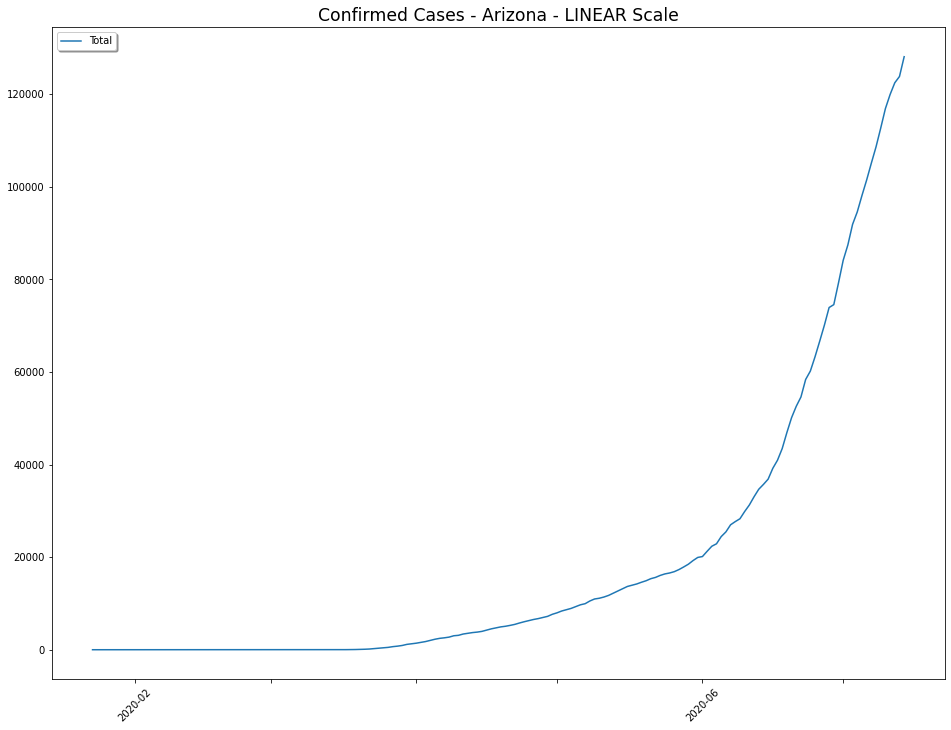

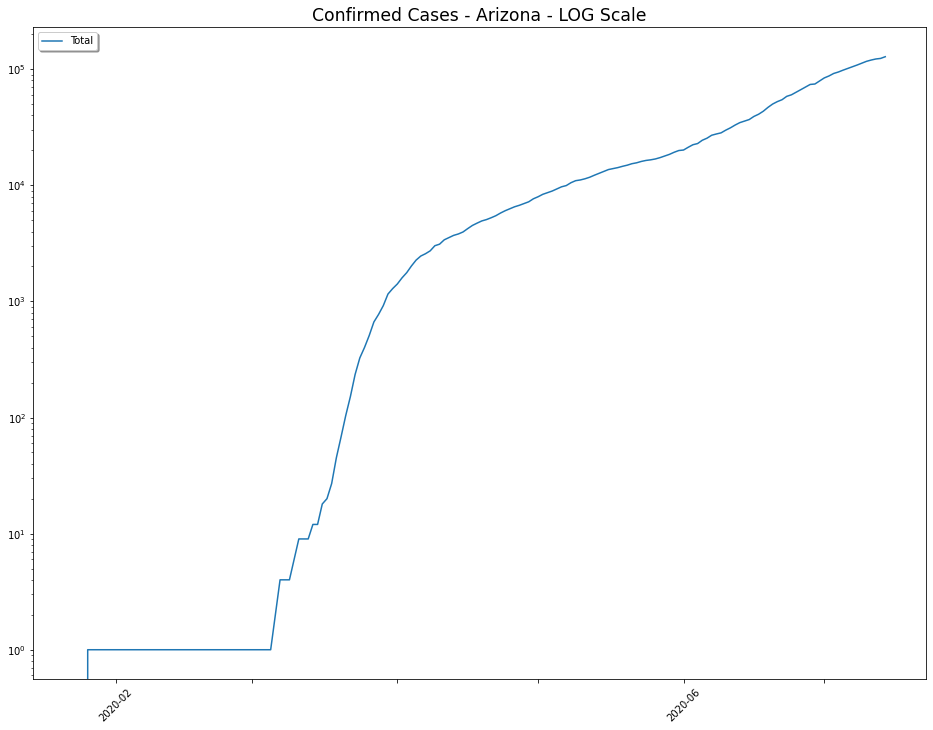

In [4]:
# Confirmed cases

# limits on the data - helps get rid of uncertainty in early data
# if end_date.lower() is 'today':
#     counts = summary[start_date:end_date]
# else:
#     counts = summary[start_date:]
counts = summary

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.set_yscale('linear')
ax.plot(counts)
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.legend(('Total',), shadow=True, loc='upper left')
plt.title('Confirmed Cases - {} - LINEAR Scale'.format(state), fontsize='xx-large')
plt.show()


fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.plot(counts)
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.legend(('Total',), shadow=True, loc='upper left')
plt.title('Confirmed Cases - {} - LOG Scale'.format(state), fontsize='xx-large')
plt.show()

<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-f3dff925db2d>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if end_date.lower() is 'today':


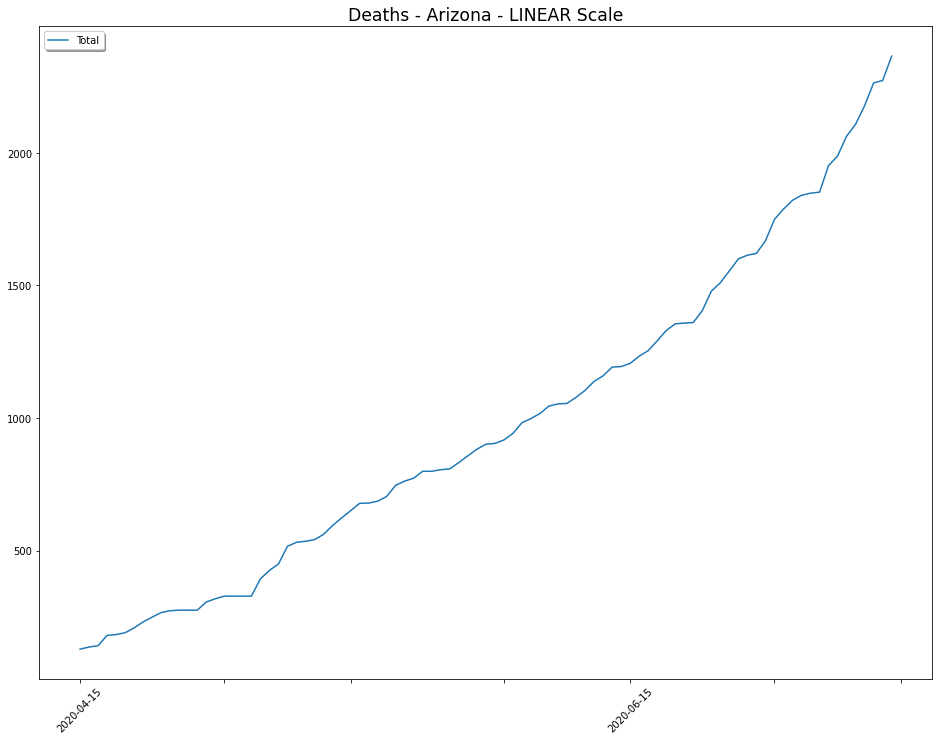

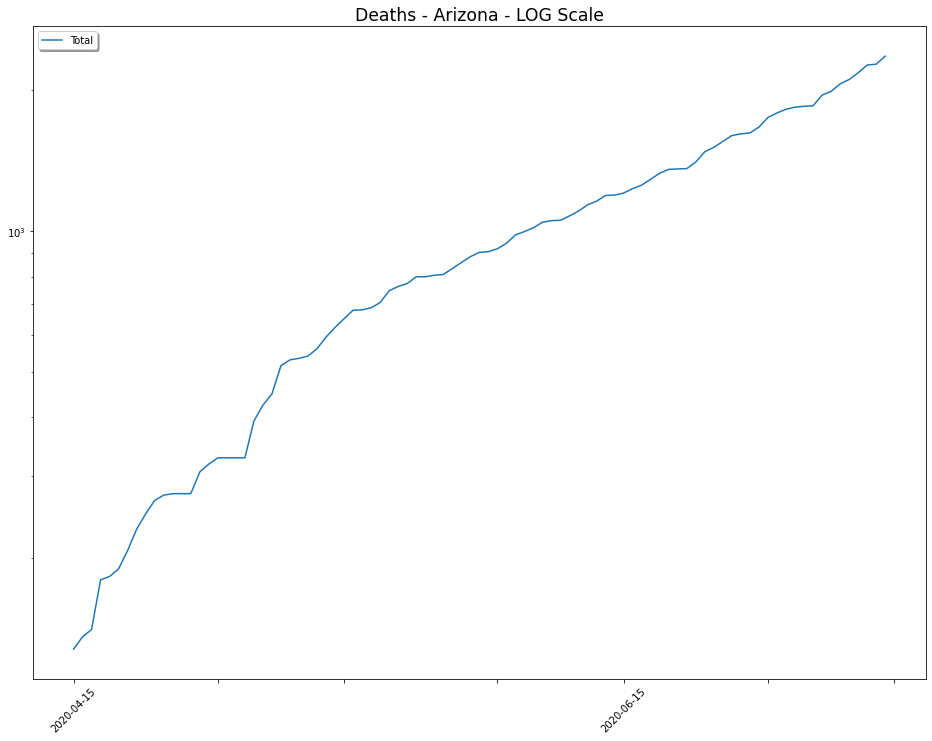

In [5]:
# Confirmed cases

# limits on the data - helps get rid of uncertainty in early data
if end_date.lower() is 'today':
    dcounts = dsummary[start_date:end_date]
else:
    dcounts = dsummary[start_date:]

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.set_yscale('linear')
ax.plot(dcounts)
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.legend(('Total',), shadow=True, loc='upper left')
plt.title('Deaths - {} - LINEAR Scale'.format(state), fontsize='xx-large')
plt.show()


fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.plot(dcounts)
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xticks(rotation=45)
plt.legend(('Total',), shadow=True, loc='upper left')
plt.title('Deaths - {} - LOG Scale'.format(state), fontsize='xx-large')
plt.show()

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-6-b019244815da>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if end_date.lower() is 'today':


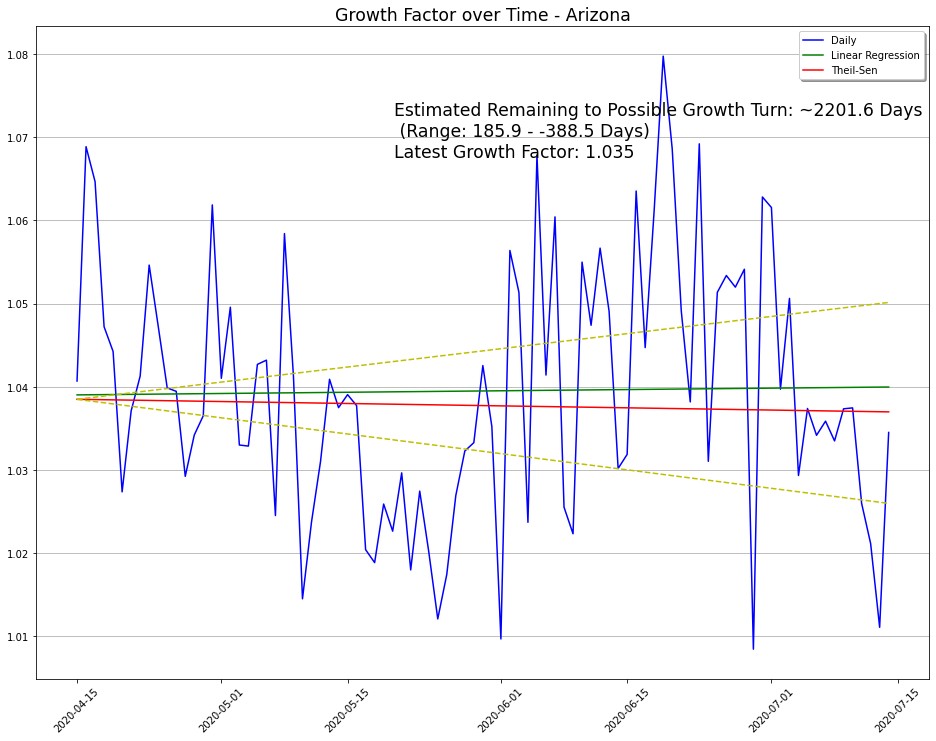

In [6]:
# Growth Factor Analysis

# Growth is calculated as (day / (day - 1))
growth = summary / summary.shift()
growth = growth.fillna(growth.median()) # get rid of NaNs
if end_date.lower() is 'today':
    growth = growth[start_date:end_date]
else:
    growth = growth[start_date:]

# growth = growth[start_date:] # limit to drop out early data w/ lots of uncertainty

# linreg to establish the growth trend - DEPRECATED
lr = stats.linregress(range(growth.shape[0]), growth.values)
linreg = pd.Series([(lr[1] + lr[0] * x) for x in range(growth.shape[0])],
                   index=growth.index)

# theil slope to establish the growth trend
ts = stats.theilslopes(growth.values, range(growth.shape[0]), 0.95)
tslopes = pd.Series([(ts[1] + ts[0] * x) for x in range(growth.shape[0])], 
                    index=growth.index)
tslopes_lower = pd.Series([(ts[1] + ts[2] * x) for x in range(growth.shape[0])], 
                          index=growth.index)
tslopes_upper = pd.Series([(ts[1] + ts[3] * x) for x in range(growth.shape[0])], 
                          index=growth.index)

# How long until growth factor 1? 
days_to_one = ((1 - ts[1]) / ts[0]) - growth.shape[0]
days_to_one_low = ((1 - ts[1]) / ts[2]) - growth.shape[0]
days_to_one_hi = ((1 - ts[1]) / ts[3]) - growth.shape[0]

# plot the growth factor and trend

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.plot(growth, 'b-')
ax.plot(linreg, 'g-')
ax.plot(tslopes, 'r-')
ax.plot(tslopes_upper, 'y--')
ax.plot(tslopes_lower, 'y--')
ax.text(.4, .8,
        'Estimated Remaining to Possible Growth Turn: ~{:.1f} Days\n (Range: {:.1f} - {:.1f} Days)\nLatest Growth Factor: {:.3f}'\
        .format(days_to_one, days_to_one_low, days_to_one_hi, growth[-1]), 
        fontsize='xx-large', transform=ax.transAxes)
plt.xticks(rotation=45)
plt.legend(('Daily', 'Linear Regression', 'Theil-Sen'), shadow=True, loc='upper right')
plt.title('Growth Factor over Time - {}'.format(state), fontsize='xx-large')
plt.grid(axis='y')
plt.show()

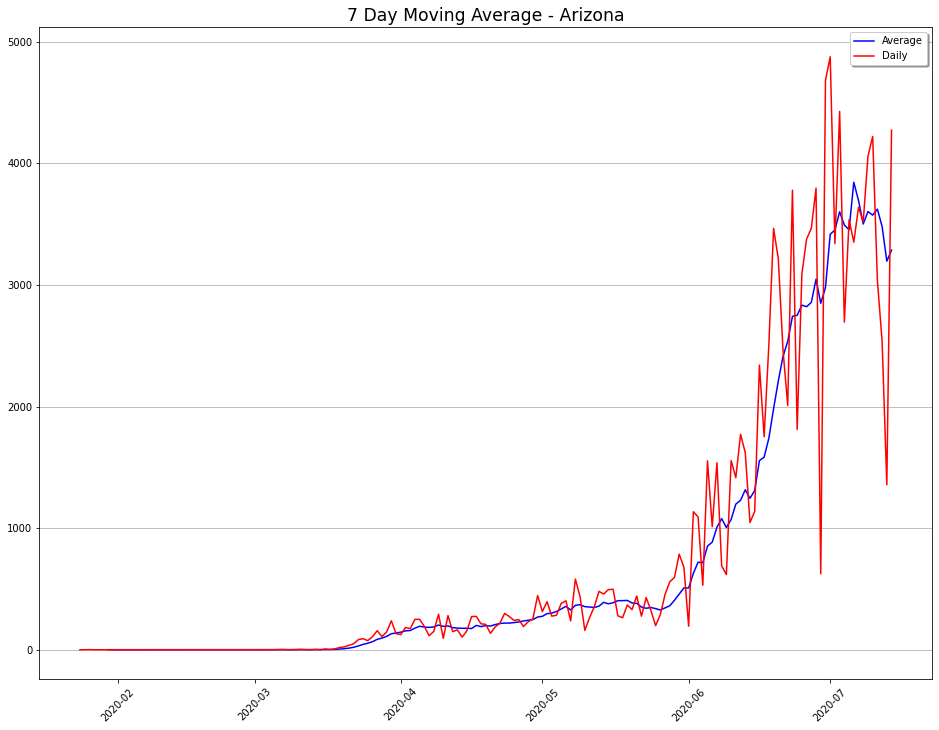

Total Confirmed Cases 4/15/20 - Today: 128097

Daily New Cases:
2020-01-24       0.0
2020-01-25       0.0
2020-01-26       1.0
2020-01-27       0.0
2020-01-28       0.0
               ...  
2020-07-10    4221.0
2020-07-11    3038.0
2020-07-12    2537.0
2020-07-13    1357.0
2020-07-14    4273.0
Length: 173, dtype: float64
____________________
Total Deaths 4/15/20 - Today: 2365

Daily Deaths:
2020-04-16     8.0
2020-04-17     5.0
2020-04-18    39.0
2020-04-19     3.0
2020-04-20     7.0
              ... 
2020-07-10    45.0
2020-07-11    70.0
2020-07-12    86.0
2020-07-13     9.0
2020-07-14    92.0
Length: 90, dtype: float64
Death Rate: 1.85%


In [7]:
total_cases = counts[-1]
daily_counts = (counts - counts.shift()).dropna()
rolling_7day = daily_counts.rolling(7).mean()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.plot(rolling_7day, 'b-')
ax.plot(daily_counts, 'r-')
plt.xticks(rotation=45)
plt.legend(('Average', 'Daily'), shadow=True, loc='upper right')
plt.title('7 Day Moving Average - {}'.format(state), fontsize='xx-large')
plt.grid(axis='y')
plt.show()

print('Total Confirmed Cases {} - {}: {}\n'.format(start_date, end_date, total_cases))
print('Daily New Cases:\n{}'.format(daily_counts))
print('_' * 20)

total_deaths = dcounts[-1]
daily_deaths = (dcounts - dcounts.shift()).dropna()

print('Total Deaths {} - {}: {}\n'.format(start_date, end_date, total_deaths))
print('Daily Deaths:\n{}'.format(daily_deaths))

print('Death Rate: {:.2f}%'.format((total_deaths/total_cases) * 100))

In [8]:
# some set up

# gets the data from CovidTracking.com.
def getDataCovidTracking(get_states=False):
    
    if get_states is False:
        url = 'https://covidtracking.com/api/v1/us/daily.json'
    else:
        url = 'https://covidtracking.com/api/v1/states/daily.json'
        
    locations = {'us': '', 'states': ''}
        
    for x, location in enumerate(locations):
        
        url = 'https://covidtracking.com/api/v1/{}/daily.json'.format(location)
        
        data = pd.read_json(url)    
    # fix the dates
        data.loc[:, 'date'] = data.date.apply(str)
        data.loc[:, 'date'] = data.date.apply(lambda x: '{}-{}-{}'.format(x[4:6],x[6:8],x[0:4]))
        data = data.set_index('date').sort_index()
        locations[location] = data
    
    return locations

def pltStats(title=None, cols=[], scale='linear', data=None, marker=None):
    
    if data is None:
        print('Data needs to be fed here.')
        return

    # set up the framework
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(111)
    ax.set_yscale(scale)

    # add the plots
    for n, col in enumerate(cols):
        
        ax.plot(data[col])
    

    ### if marker is not None:
    #maxX = data.max().max()
#     ax.add_line('06-01-2020', 0, 1000, label='Protests Start')
    
    # adjust the tics on the x axis
    every_nth = 4
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    plt.xticks(rotation=45)
    
    # legendary, this part...
    plt.legend(cols, shadow=True, loc='upper left')
    plt.title('{}'.format(title), fontsize='xx-large')
    plt.grid(axis='y')
    plt.show()

    
def makeStats(data=None):
    
        df = data
        df.loc[:, 'mortalityRate'] = (df.death / df.positive) * 100
    
        # daily delta = today - yesterday then smooth with a rolling 3 mean
        r = 3
        df.loc[:, 'positiveDaily'] = (df.positive - df.positive.shift()).rolling(r).mean()
        df.loc[:, 'negativeDaily'] = (df.negative - df.negative.shift()).rolling(r).mean()
        df.loc[:, 'deathDaily'] = (df.death - df.death.shift()).rolling(r).mean()
        df.loc[:, 'hospitalizedDaily'] = (df.hospitalizedCurrently - df.hospitalizedCurrently.shift()).rolling(r).mean()
        df.loc[:, 'hospitalizedDaily2'] = (df.hospitalizedCurrently - df.hospitalizedCurrently.shift())
        df.loc[:, 'recoveredDaily'] = (df.recovered - df.recovered.shift()).rolling(r).mean()

        # Growth factor = today / yesteday then take a rolling 7 mean.
        r = 7
        df.loc[:,'positiveGrowth'] = (df.positive / df.positive.shift()).rolling(r).mean()
        df.loc[:, 'deathGrowth'] = (df.death / df.death.shift()).rolling(r).mean()
        return df


def makeReport(reports=None, data=None, start_date=None):

        # need to make the stats first
#         data = makeStats(data=data)
        
        # make the graphs
        for title, cols in reports.items():
            print('{} - {} - {}'.format('#' * 20, location, '#' * 20))
            title = '{} - {}'.format(location, title)
            pltStats(title=title, cols=cols, data=data[data.index >= start_date])
            
    







In [9]:
# get the data
us, allStates = getDataCovidTracking().values()

# put it all in an dict so we end up with location: data that we can iterate through:
states = {'US': us}

# split out the states we want and add them to the dict
for x, y in enumerate(allStates.state.unique()):
    thisState = allStates.loc[allStates['state'] == y, :]
    states[y] = thisState

/Users/schwim/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/schwim/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#################### - WA - ####################


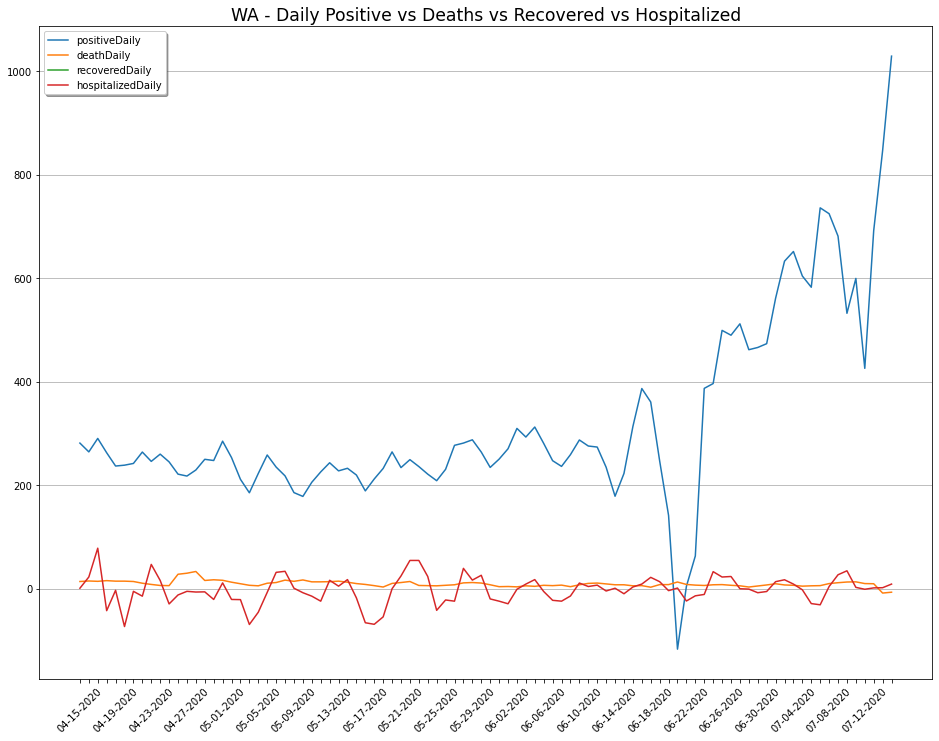

#################### - WA - ####################


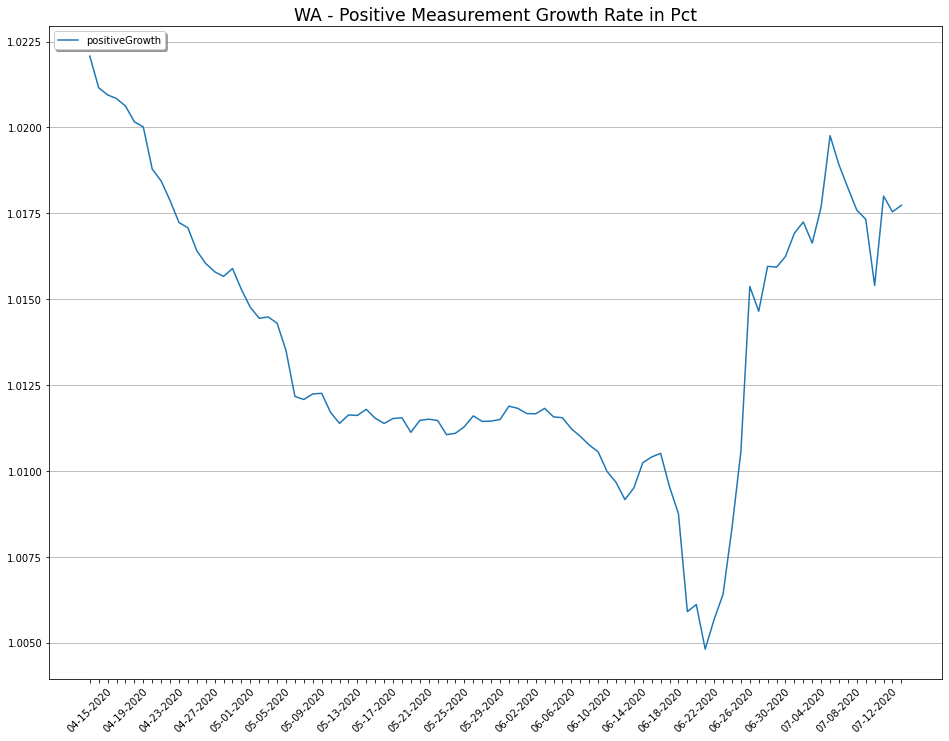

#################### - WA - ####################


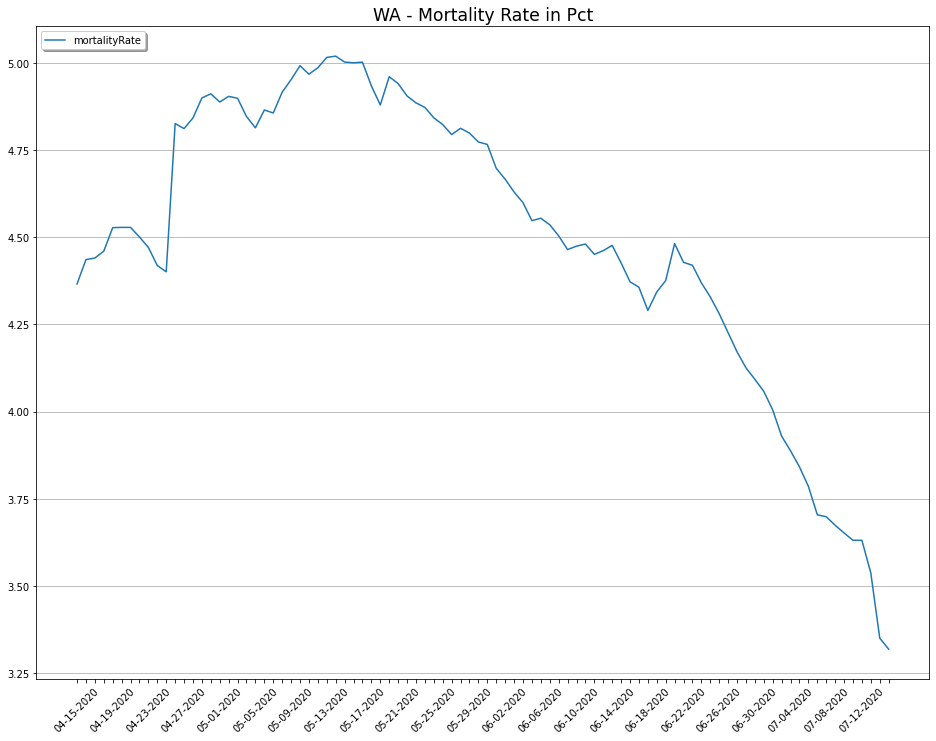

#################### - WA - ####################


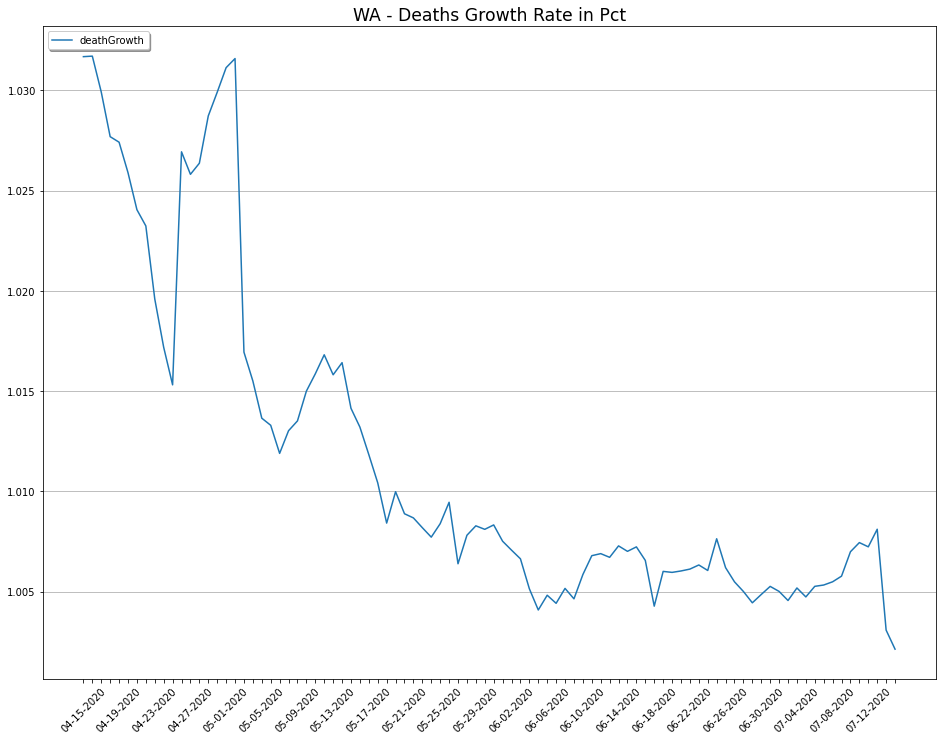

#################### - AZ - ####################


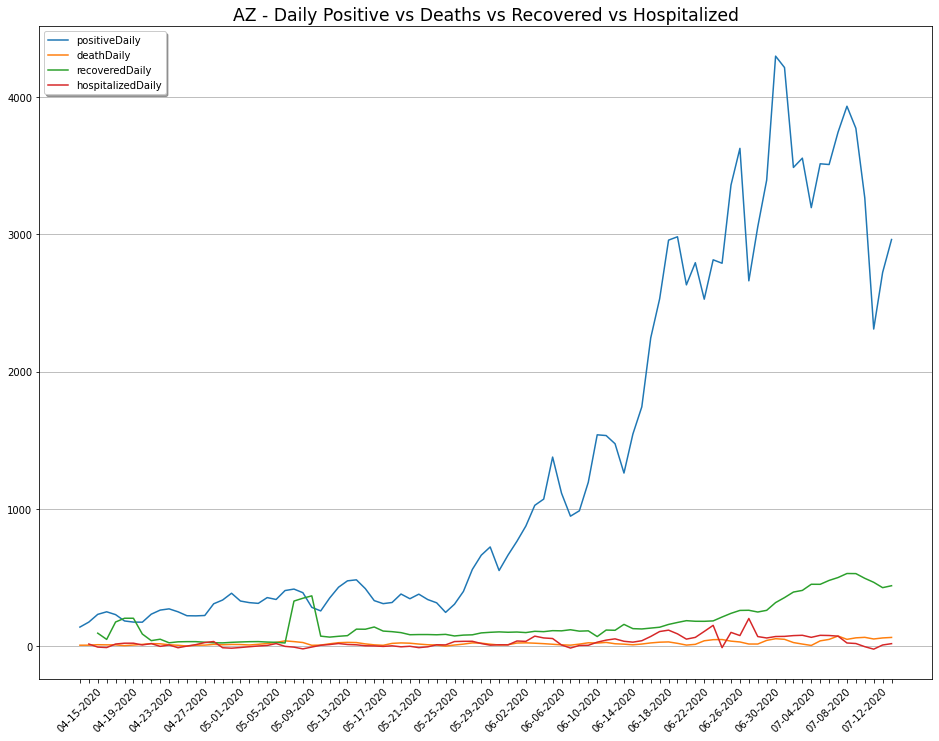

#################### - AZ - ####################


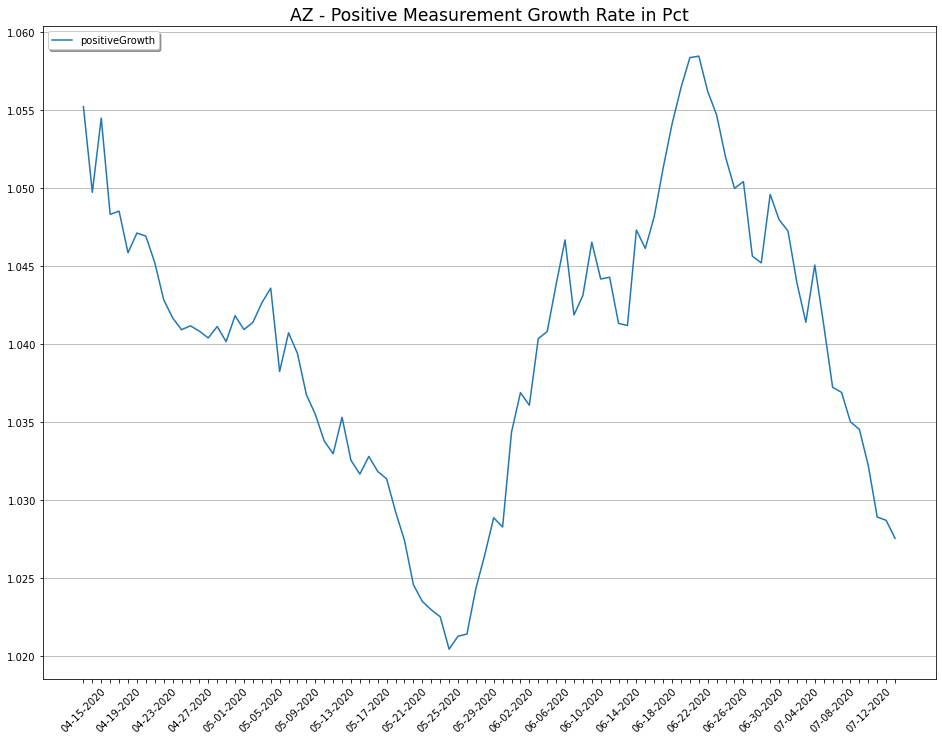

#################### - AZ - ####################


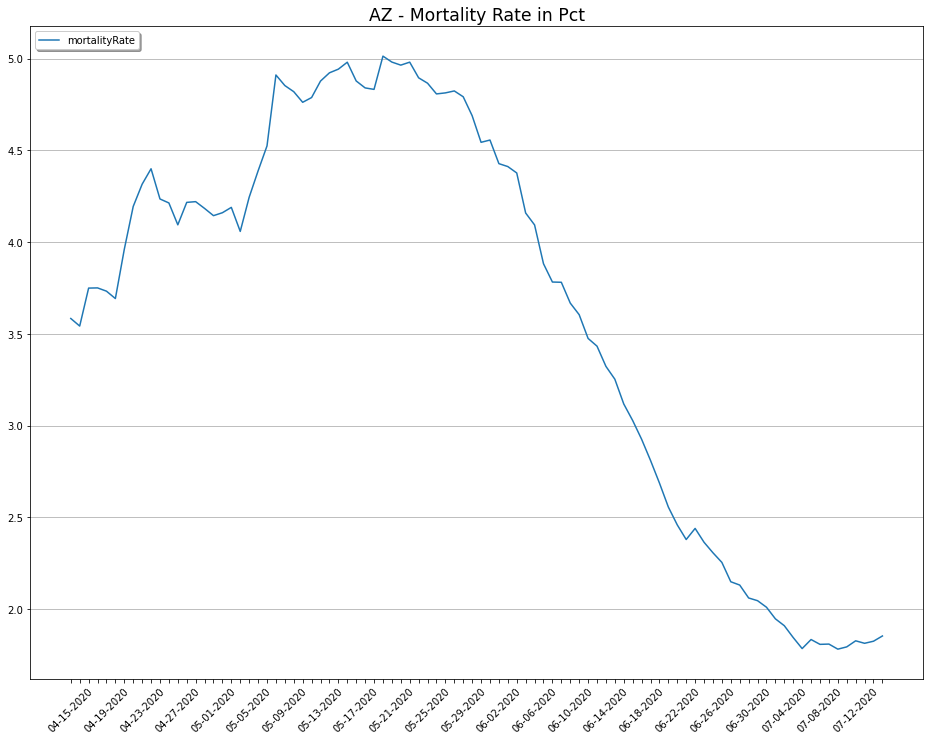

#################### - AZ - ####################


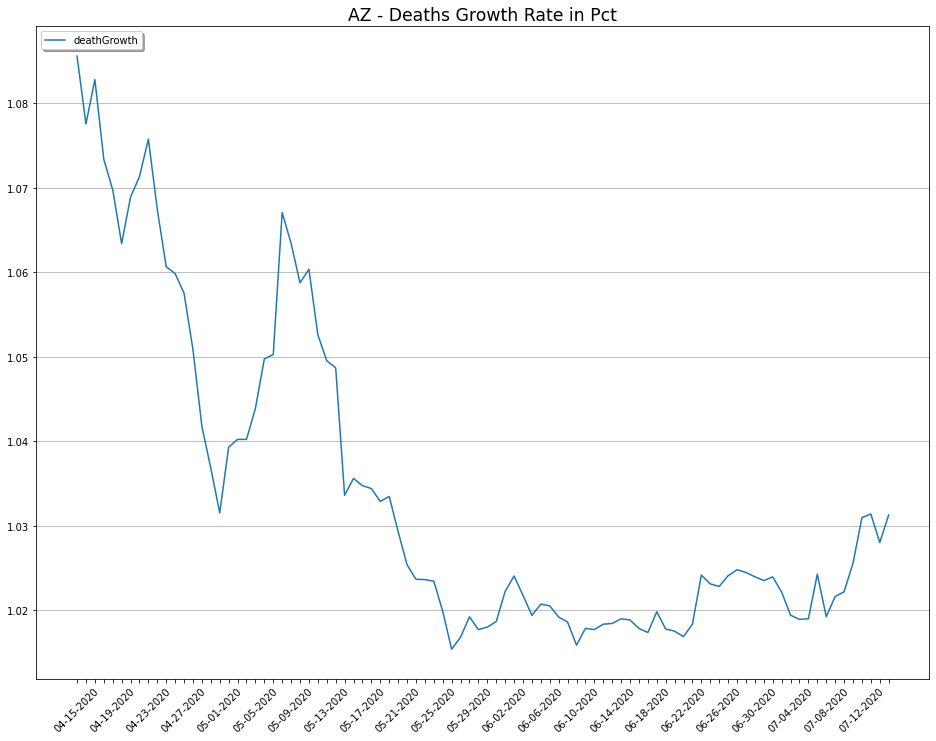

#################### - CA - ####################


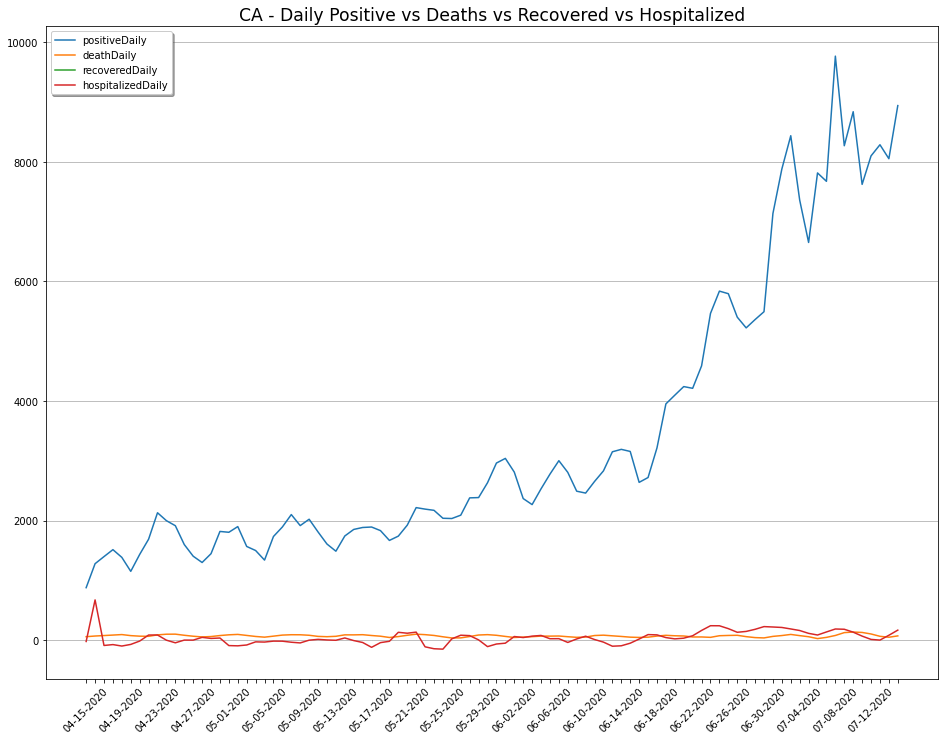

#################### - CA - ####################


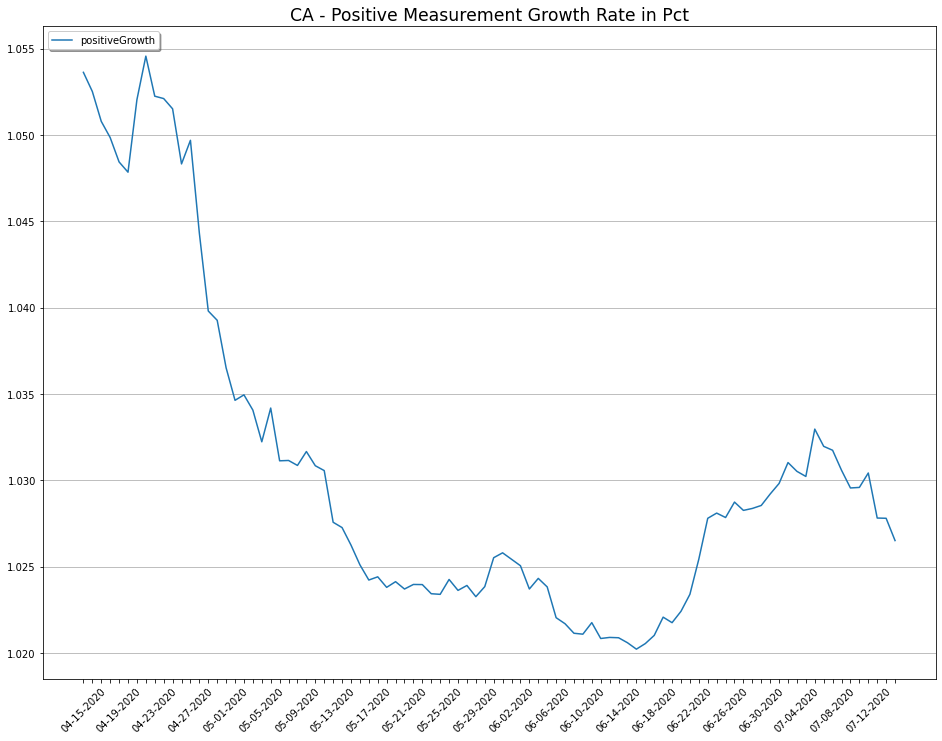

#################### - CA - ####################


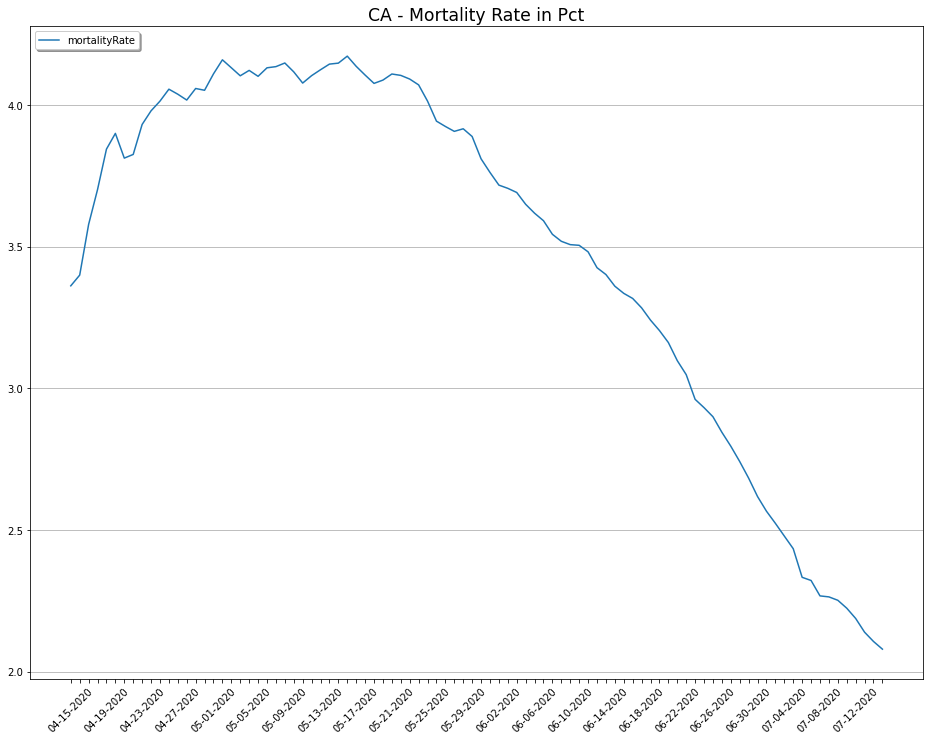

#################### - CA - ####################


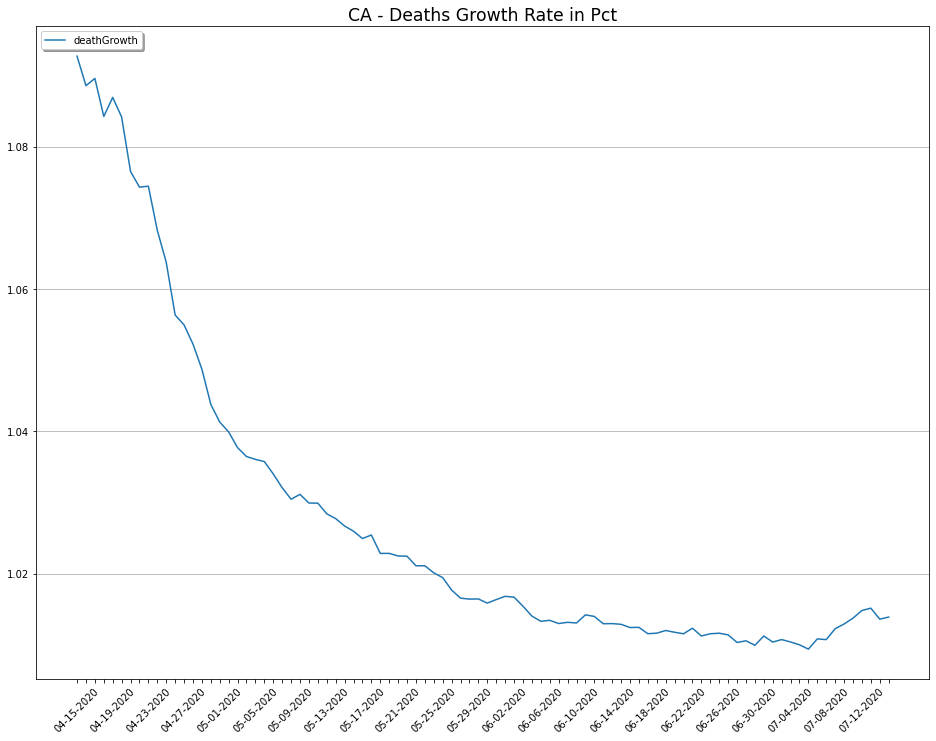

In [10]:
reportAll = False
roi = ['AZ', 'CA', 'WA']

start_date = '04-15-2020'

reports = {
    # 'Cumulative Postive vs. Deaths vs. Recovered vs Hospitalized' : ['positive', 'death', 'recovered', 'hospitalizedCumulative'],
    'Daily Positive vs Deaths vs Recovered vs Hospitalized' : ['positiveDaily', 'deathDaily', 'recoveredDaily', 'hospitalizedDaily'],
    'Positive Measurement Growth Rate in Pct': ['positiveGrowth'],
    'Mortality Rate in Pct': ['mortalityRate'],
    'Deaths Growth Rate in Pct' : ['deathGrowth']
}

positiveAll = pd.DataFrame()
positiveGrowthAll = pd.DataFrame()

for x, location in enumerate(states):
    if reportAll is True:
        states[location] = makeStats(data=states[location])

        makeReport(reports=reports, data=states[location], start_date=start_date)
        positiveAll.loc[:, location] = states[location].positiveDaily
        positiveGrowthAll.loc[:, location] = states[location].positiveGrowth

    elif location in roi:
        states[location] = makeStats(data=states[location])

        makeReport(reports=reports, data=states[location], start_date=start_date)
        positiveAll.loc[:, location] = states[location].positiveDaily
        positiveGrowthAll.loc[:, location] = states[location].positiveGrowth

   
  

In [11]:
states['AZ']

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,...,grade,mortalityRate,positiveDaily,negativeDaily,deathDaily,hospitalizedDaily,hospitalizedDaily2,recoveredDaily,positiveGrowth,deathGrowth
date,,,,,,,,,,,,,,,,,,,,,
03-04-2020,AZ,2.0,27.0,5.0,NaN,4.0,NaN,NaN,NaN,NaN,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03-05-2020,AZ,2.0,28.0,6.0,NaN,5.0,NaN,NaN,NaN,NaN,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03-06-2020,AZ,3.0,33.0,15.0,NaN,6.0,NaN,NaN,NaN,NaN,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03-07-2020,AZ,5.0,44.0,7.0,NaN,6.0,NaN,NaN,NaN,NaN,...,,NaN,1.000000,5.666667,NaN,NaN,NaN,NaN,NaN,NaN
03-08-2020,AZ,5.0,44.0,7.0,NaN,6.0,NaN,NaN,NaN,NaN,...,,NaN,1.000000,5.333333,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
07-11-2020,AZ,119930.0,564060.0,NaN,3485.0,5750.0,899.0,NaN,620.0,NaN,...,,1.793546,3772.000000,10534.666667,62.666667,21.333333,53.0,530.333333,1.034554,1.025576
07-12-2020,AZ,122467.0,573705.0,NaN,3432.0,5795.0,922.0,NaN,631.0,NaN,...,,1.826615,3265.333333,11105.000000,66.333333,-1.666667,-53.0,496.000000,1.032234,1.030971
07-13-2020,AZ,123824.0,578602.0,NaN,3373.0,5839.0,936.0,NaN,671.0,NaN,...,,1.813057,2310.666667,8761.000000,54.333333,-19.666667,-59.0,467.000000,1.028935,1.031403
